In [1]:
from matplotlib import image
from matplotlib import pyplot as plt

In [2]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [4]:
from sklearn.neighbors import KNeighborsClassifier


In [5]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr

In [6]:
import random

In [7]:
from tqdm import tqdm

In [8]:
import pandas as pd

In [9]:
from sklearn import model_selection, metrics

In [10]:
%run technical_functions/cv_and_reclassification_methods.ipynb

In [11]:
%run technical_functions/functions_geotransforms.ipynb

Попробуем отклассифицировать тензор признаков GLCM-матрицы.

In [327]:
import scipy.io

In [351]:
T = np.load('properties_55/GLCM_properties_55.npy')
#EV_properties = scipy.io.loadmat('Konstantinovky_TestReg_pan_GLCM_Dx27_Ngs8_Ndir1.mat')
#T = EV_properties['X']

In [352]:
T.shape

(424, 448, 19)

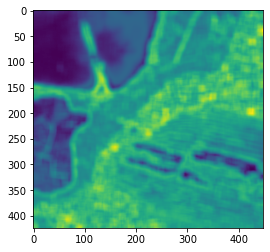

In [353]:
plt.imshow(T[:, :, 9])

In [354]:
np.any(np.isnan(T[:, :, 4]))

True

In [355]:
T = np.concatenate((T[:, :, :4], T[:, :, 5:12], T[:, :, 13:]), axis = 2)

In [356]:
np.any(np.isnan(T))

False

Загружаем карту.

In [357]:
map_konst = gdal.Open('Konstantinovsky_map.tif')
konstantinovsky_mult = rxr.open_rasterio("geotiff/Konstantinovky_TestReg_mult.tif")
konstantinovsky_mult_gdal = gdal.Open("geotiff/Konstantinovky_TestReg_mult.tif")
map_konst_rasterio = rxr.open_rasterio("Konstantinovsky_map.tif").squeeze()
m_m, m_n = konstantinovsky_mult.shape[1], konstantinovsky_mult.shape[2]
geo_trans_mult = konstantinovsky_mult_gdal.GetGeoTransform()
proj_mult = konstantinovsky_mult_gdal.GetProjection()
geo_trans_pan = map_konst.GetGeoTransform()
proj_pan = map_konst.GetProjection()
pixels_pan_list = []
for i in range(1, m_m + 1):
    a = []
    for j in range(1, m_n + 1):
        a.append((i, j))
    a_coords = pix2coord(a, geo_trans_mult, proj_mult) #были пиксели в мультиканальном, стали координаты
    a_pixels_in_pan = coord2pix(a_coords, geo_trans_pan, proj_pan)
    pixels_pan_list.append(a_pixels_in_pan)
map_konst_ = np.zeros((T.shape[0], T.shape[1]))
cnt_i = 0
cnt_j = 0
for line in tqdm(pixels_pan_list):
    cnt_j = 0
    for elem in line:
        i, j = elem
        i = int(i - 1)
        j = int(j - 1)
        map_konst_[cnt_i][cnt_j] = map_konst_rasterio.values[i][j]
        cnt_j += 1
    cnt_i += 1

100%|███████████████████████████████████████████████████████████████████████████████| 424/424 [00:02<00:00, 150.92it/s]


In [358]:
map_konst_.shape

(424, 448)

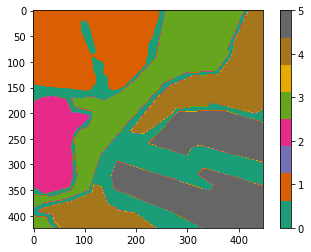

In [359]:
plt.imshow(map_konst_, cmap=plt.get_cmap('Dark2'))
plt.colorbar()

In [360]:
import skimage.io
import skimage.filters

sigma = 7.0
for i in range(11):
    T[:, :, i] = skimage.filters.gaussian(
        T[:, :, i], sigma=(sigma, sigma), truncate=3.5, multichannel=False)

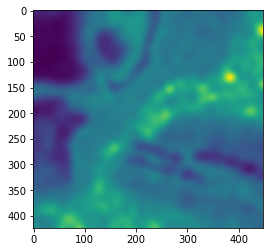

In [361]:
plt.imshow(T[:, :, 6])

In [362]:
from sklearn.preprocessing import StandardScaler
T = T.reshape((T.shape[0] * T.shape[1], 17))
scaler = StandardScaler()
T = scaler.fit_transform(T)

In [363]:
map_konst_ = map_konst_.reshape((map_konst_.shape[0] * map_konst_.shape[1], 1))

In [364]:
data = np.concatenate((T, map_konst_), axis = 1)

In [365]:
ones = data[np.argwhere(map_konst_.squeeze() == 1), :].squeeze()
data_ = np.array(random.sample(list(ones), 10000))
for i in range(2, 6):
    tmp = data[np.argwhere(map_konst_.squeeze() == i), :].squeeze()
    data_ = np.concatenate((data_, np.array(random.sample(list(tmp), 10000))), axis = 0)

In [366]:
data_.shape

(50000, 18)

In [367]:
X = data_[:, :17]
y = data_[:, 17]

In [368]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0, stratify = y) 

In [369]:
qda = QuadraticDiscriminantAnalysis()

In [370]:
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [371]:
pred_qda = qda.predict(T.reshape(424 * 448, 17))

In [372]:
p = pred_qda.reshape((424, 448))

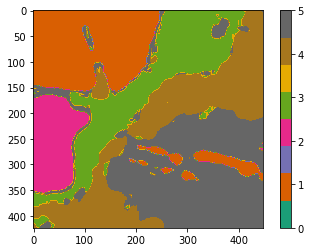

In [373]:
plt.imshow(pred_qda.reshape(424, 448), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

In [374]:
q = QuadraticDiscriminantAnalysis()
mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
mt

(<pandas.io.formats.style.Styler at 0x12497cc0188>,
 [  10-fold cross-validation                                       \
              Omission error Commission error Producer’s accuracy   
  1                 0.000393         0.000000            0.999607   
  2                 0.004400         0.000912            0.995600   
  3                 0.069102         0.010416            0.930898   
  4                 0.013715         0.034976            0.986285   
  5                 0.022189         0.060841            0.977811   
  
                     
    User’s accuracy  
  1        1.000000  
  2        0.999088  
  3        0.989584  
  4        0.965024  
  5        0.939159  ,
    Reclassification                                                     
      Omission error Commission error Producer’s accuracy User’s accuracy
  1         0.000303         0.000000            0.999697        1.000000
  2         0.004545         0.000912            0.995455        0.999088
  3        

In [116]:
mt[5].to_excel("results/GLCM/GLCM_rcls_errors.xlsx")

In [117]:
mt[4].to_excel("results/GLCM/GLCM_cv_errors.xlsx")

In [118]:
mt[1][0].to_excel("results/GLCM/GLCM_cv_conf_matrix.xlsx")

In [119]:
mt[1][1].to_excel("results/GLCM/GLCM_rcls_conf_matrix.xlsx")

In [120]:
pic = pred_qda.reshape(T.shape[0], T.shape[1])
rows, cols = pic.shape[0], pic.shape[1]
ds = gdal.Open("geotiff/Konstantinovky_TestReg_mult.tif")
outFileName = "results/GLCM/Konstantinovsky_GLCM.tif"

In [121]:
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(pic)
outdata.FlushCache()

QDA с отсечкой (классифицируем не все)

In [122]:
X = []
y = []
cnt = np.zeros(18)
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        if map_konst_[i][j] != 0 and cnt[int(map_konst_[i][j])- 1] < 9500:
            X.append(T[i, j, :])
            y.append(map_konst_[i, j])
            cnt[int(map_konst_[i][j])- 1] += 1

In [123]:
X = np.array(X)
y = np.array(y)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)#, stratify = y) переделать

In [125]:
qda = QuadraticDiscriminantAnalysis()

In [126]:
qda.fit(X_train, y_train)

C:\Users\abazarova\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [143]:
pred_qda_ = qda.predict_proba(X)
pred_qda = pred_qda_.reshape((pred_qda_.shape[0] * pred_qda_.shape[1], 1))

In [158]:
np.count_nonzero((0.1 < pred_qda_) * (0.9 > pred_qda_))

94

In [18]:
konstantinovsky = rxr.open_rasterio("geotiff/Konstantinovky_TestReg_mult.tif").squeeze()

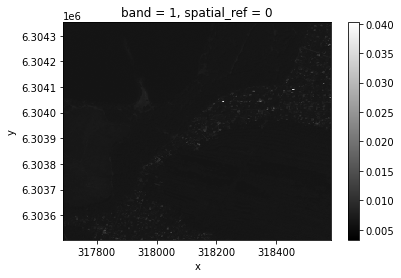

In [21]:
#f, ax = plt.subplots(figsize=(10, 5))
konstantinovsky[0].plot(cmap = 'gray')
plt.show()